### Use Singular Value Decomposition (SVD) for further Preprocessing

The purpose of the first part of this file is to use SVD to get the top 1000 components of each images before creating the foreground background. 

In [1]:
import numpy as np
import pandas as pd
from PIL import Image
import numpy as np
import os

def get_images_in_folder(folder_path):
    # Get all files in the folder
    all_files = os.listdir(folder_path)
    # Filter out only the image files
    image_files = [file for file in all_files if file.lower().endswith(('.jpg'))]
    return image_files


def image_to_matrix(image_path):
    img = Image.open(image_path)
    img_array = np.array(img)
    img_flatten_i = img_array.flatten()
    img.close()
    return img_flatten_i

In [4]:
import time 
start = time.time()

folder_path = '.../celeba_data/reduced_img_celeba'  # create a new folder called reduced_img_celeba to store the reduced images
images = get_images_in_folder(folder_path)
images_sorted = np.sort(images)                     # sort img based on the names of the img (i.e., "000001.png")

In [41]:
flattened_images = []

for image_file in images_sorted:
    image_path = os.path.join(folder_path, image_file)
    img_flatten_i = image_to_matrix(image_path)
    flattened_images.append(img_flatten_i)

In [42]:
flattened_images = np.array(flattened_images)
print(flattened_images.shape)

(202599, 12288)


In [44]:
flattened_images_df = pd.DataFrame(flattened_images)
# flattened_images_df.to_csv("celeba_flattened_images.csv")

compute the covariance of the matrix (flattened_images)

In [45]:
img_cov = np.cov(flattened_images.T)

In [46]:
print(img_cov.shape)

(12288, 12288)


use SVD

In [47]:
U, s, Vt = np.linalg.svd(img_cov)

In [48]:
print(U.shape)

(12288, 12288)


In [49]:
num_component = 1000
U_reduced = U[:, :1000]
print((flattened_images).shape)
print(U_reduced.shape)

(202599, 12288)
(12288, 1000)


In [51]:
reduced_flattened_images = flattened_images @ U_reduced
print(reduced_flattened_images.shape)

reduced_flattened_images_df = pd.DataFrame(reduced_flattened_images)


(202599, 1000)


Produce the csv file so that to reduce the number of code for running the dataset on hat (fore) and no hat (back)

In [ ]:
reduced_flattened_images_df.to_csv("celeba_flattened_images_reduced.csv")

### CelebA_Glasses

The purpose of this file is to preprocess the celebA dataset to get the foreground and background matrix for CDE function. 


In [2]:
import pandas as pd 
import os
import time

data_dir = '.../celeba_data'
celebA = pd.read_csv(os.path.join(data_dir, 'list_attr_celeba.csv'))

In [3]:
indices_glass= celebA.index[celebA["Eyeglasses"] == 1].tolist()
print(len(indices_glass))

13193


In [5]:
indices_no_glass= celebA.index[celebA["Eyeglasses"] != 1].tolist()
print(len(indices_no_glass))

189406


In [6]:
print(indices_glass[2])

118


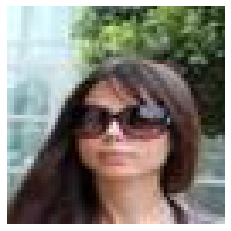

In [8]:
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg


def get_images_in_folder(folder_path):
    # Get all files in the folder
    all_files = os.listdir(folder_path)
    # Filter out only the image files
    image_files = [file for file in all_files if file.lower().endswith(('.jpg'))]
    return image_files


folder_path = '.../celeba_data/reduced_img_celeba'
images = get_images_in_folder(folder_path)
images_sorted = np.sort(images)
target_path =  os.path.join(folder_path, images_sorted[92])


def display_with_matplotlib(image_path):
    img = mpimg.imread(image_path)
    plt.imshow(img)
    plt.axis('off')  # Turn off axis numbers and ticks
    plt.show()
    
display_with_matplotlib(target_path)

In [8]:
reduced_flattened_images_df = pd.read_csv("celeba_flattened_images_reduced.csv")

# remove the first column (index column) 
reduced_flattened_images_df = reduced_flattened_images_df.drop(reduced_flattened_images_df.columns[0], axis = 1) 

In [9]:
reduced_flattened_images = reduced_flattened_images_df.values

In [10]:
images_with_glasses = reduced_flattened_images[indices_glass]
print(images_with_glasses.shape)

(13193, 1000)


In [11]:
images_with_no_glasses = reduced_flattened_images[indices_no_glass]
print(images_with_no_glasses.shape)

(189406, 1000)


In [12]:
fore = images_with_glasses
back = images_with_no_glasses

### Run Contrastive Dimension Estimation functions 

In [13]:
import numpy as np
import pandas as pd
import skdim
from scipy.linalg import eigh
from sklearn.preprocessing import scale


def id_estimators(df, k):
    # Maximum Likelihood algorithm
    MLE = skdim.id.MLE(K=k).fit(df).dimension_
    # Method Of Moments algorithm
    MOM = skdim.id.MOM().fit(df).dimension_
    L = {
        'MLE': MLE,
        'MOM': MOM,
    }
    return L


def est_V1_V2(X1, X2, d1, d2):
    OUT = {}
    p = X1.shape[1]
    Cx1 = np.cov(X1, rowvar=False)
    Cx2 = np.cov(X2, rowvar=False)
    # eigenvalues python package in increasing order
    val1, vectors1 = eigh(Cx1)
    idx = np.argsort(val1)
    descending_idx = idx[::-1]
    vectors1 = vectors1[:, descending_idx]
    V1 = vectors1[:, 0:d1]
    val2, vectors2 = eigh(Cx2)
    idx_ = np.argsort(val2)
    descending_idx_ = idx_[::-1]
    vectors2 = vectors2[:, descending_idx_]
    V2 = vectors2[:, 0:d2]
    OUT['V1'] = V1
    OUT['V2'] = V2
    return OUT


def sigma1_test_stat(X1, X2, d1, d2):
    OUT = est_V1_V2(X1, X2, d1, d2)
    U = OUT['V1']
    V = OUT['V2']
    M = np.matmul(U.T, V)
    _, cosines, _ = np.linalg.svd(M)
    cosines = np.minimum(1, np.maximum(-1, cosines))
    return cosines[::-1][0]     # first elt of reversed cosines list


def sing_vals(U, V):
    M = np.matmul(U.T, V)
    _, cosines, _ = np.linalg.svd(M)
    cosines = np.minimum(1, np.maximum(-1, cosines))
    return cosines


def boot_test(X1, X2, d1, d2, B):
    X1 = scale(X1, with_mean=True, with_std=False)
    X2 = scale(X2, with_mean=True, with_std=False)
    test_stat = sigma1_test_stat(X1, X2, d1, d2)
    n1 = len(X1)
    n2 = len(X2)
    boot_stats = []
    
    for j in range(1, B+1):
        print(j)
        idx1 = np.random.choice(range(n1), size=n1, replace=True)
        X1t = X1[idx1, :]
        combined = np.vstack((X1, X2))
        idx2 = np.random.choice(range(n1+n2), size=n2, replace=True)
        X2t = combined[idx2, :]
        boot_stats.append(sigma1_test_stat(X1t, X2t, d1, d2))
        
    p_value = np.mean(boot_stats < test_stat)
    return {'test_stat': test_stat, 'p_value': p_value}


def CD(X1, X2, d1, d2, epsilon=0.1, B=1000):    #1000
    p = X1.shape[1]
    OUT = est_V1_V2(X1, X2, d1, d2)
    singular_vals = sing_vals(OUT['V1'], OUT['V2'])
    singular_vals = singular_vals[::-1]
    L = {}
    L['CD'] = sum(singular_vals < 1 - epsilon)  + max(d1 - d2, 0)
    test = boot_test(X1, X2, d1, d2, B)
    L['test_stat'] = test['test_stat']
    L['p_value'] = test['p_value']
    L['singular_vals'] = singular_vals
    L['d1'] = d1
    L['d2'] = d2
    return L


def CDE(fg, bg):
    L1 = id_estimators(fg, 10)
    d1 = round(L1["MOM"])
    L2 = id_estimators(bg, 10)
    d2 = round(L2["MOM"])
    return CD(fg, bg, d1, d2)

In [14]:
np.random.seed(42)
CDE(fore, back)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277


{'CD': 1,
 'test_stat': 0.2150708375406219,
 'p_value': 0.138,
 'singular_vals': array([0.21507084, 0.97230582, 0.97480689, 0.98024964, 0.98407968,
        0.98931222, 0.98990675, 0.99095241, 0.99190903, 0.99358441,
        0.99484996, 0.99528738, 0.99627854, 0.99651518, 0.99763634,
        0.99792237, 0.99859433, 0.99861639, 0.99935396, 0.99954611,
        0.99990258]),
 'd1': 21,
 'd2': 28}

In [ ]:
end = time.time()
elapsed = end - start 
print(f'Time taken: {elapsed: .6f} seconds')